# Fused Softmax

Code is run and tested on my Nvidia 3090 GPU

In [2]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = driver.active.get_active_torch_device()

In [13]:
# naive softmax
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    print(x)
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    print(x_max)
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret


# optimized version of softmax from pytorch directly
def pytorch_softmax(x):
    return torch.softmax(x, axis=1)

In [31]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, 
                   BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator

        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

    

In [32]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]

def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 8

    # Number of software pipelining stages. high level is more stages if with more SRAM
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared

    # this is to check whether number of registers and SRAM will be too much that will cause delay, might be different on different architecture
    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)

    # occupancy above is the 
    num_programs = NUM_SM * occupancy
    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y



### Test whether it's working

In [35]:
torch.manual_seed(0)
x = torch.randn(1893, 790, device=DEVICE)
y_triton = softmax(x)
y_torch = pytorch_softmax(x)
assert torch.allclose(y_triton, y_torch)

### Benchmark

tensor([[ 1.6431e-01,  3.8699e-01,  4.4976e-02,  ..., -2.7858e-01,
          9.1387e-01,  1.8492e-01],
        [ 6.2378e-01, -1.7461e+00,  5.4369e-01,  ..., -1.6651e-01,
          9.8453e-02, -6.7327e-01],
        [-2.0044e-02, -7.9789e-02, -1.4966e+00,  ...,  5.1329e-01,
         -7.3447e-01, -4.9127e-01],
        ...,
        [-1.3826e+00,  5.6342e-01, -6.7900e-02,  ..., -3.7169e-01,
         -1.1499e+00,  1.1918e+00],
        [ 5.2518e-01, -3.6143e-01,  8.8638e-01,  ..., -6.5594e-05,
          2.7551e-01,  5.7348e-01],
        [ 7.6362e-01,  1.1714e-01,  4.6165e-01,  ...,  6.1138e-01,
          1.1719e+00, -1.7891e+00]], device='cuda:0')
tensor([3.1705, 2.2737, 2.1244,  ..., 2.7158, 2.8006, 2.8630], device='cuda:0')
tensor([[ 1.6431e-01,  3.8699e-01,  4.4976e-02,  ..., -2.7858e-01,
          9.1387e-01,  1.8492e-01],
        [ 6.2378e-01, -1.7461e+00,  5.4369e-01,  ..., -1.6651e-01,
          9.8453e-02, -6.7327e-01],
        [-2.0044e-02, -7.9789e-02, -1.4966e+00,  ...,  5.1329e-01

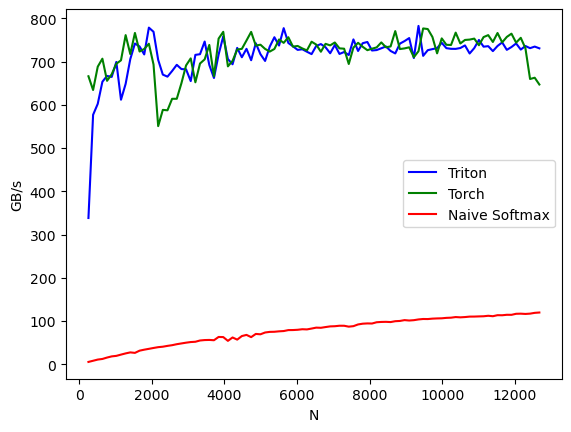

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0  338.222867  666.034569       5.392676
1     384.0  576.891550  634.265102       8.090882
2     512.0  602.265538  688.196973      10.825118
3     640.0  653.343162  706.680599      12.242531
4     768.0  666.824093  655.489610      15.494600
5     896.0  664.526515  670.613744      18.198167
6    1024.0  699.156227  695.040259      19.403623
7    1152.0  611.781100  702.889493      22.311211
8    1280.0  648.447873  761.229076      25.095627
9    1408.0  705.745471  717.411045      27.419910
10   1536.0  741.795618  766.209449      26.318987
11   1664.0  734.885391  723.193500      31.421218
12   1792.0  716.522210  729.240653      33.711895
13   1920.0  778.517989  741.257123      35.657526
14   2048.0  768.896040  693.201500      37.667886
15   2176.0  704.009528  550.681563      39.528232
16   2304.0  669.848540  588.282565      40.582297
17   2432.0  665.144197  587.312357      42.494074
18   2560.

In [39]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names = ['N'],
        x_vals  = [128 * i for i in range(2, 100)],
        line_arg='provider',
        line_vals=['triton', 'torch', 'naive_softmax'],
        line_names=["Triton", "Torch", "Naive Softmax"],
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    # stream = getattr(torch, DEVICE.type).Stream()
    # getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: pytorch_softmax(x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)